In [ ]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['DDE_BACKEND'] = 'pytorch'

In [ ]:
import deepxde as dde 
import numpy as np 

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/userhome/jeon_mg/miniforge3/envs/pinn_torch/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [ ]:
layer_size = [3] + [256] * 8 + [3]
activation = 'sin'
initializer = 'Glorot normal'
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(None, net)
model.compile('adam', lr=5e-4)

Compiling model...
'compile' took 0.289131 s



In [ ]:
model.restore('/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_notebooks/deepxde/model_deepxde/model_deepxde-5000.pt')

In [ ]:
Nx = 513
Ny = 257
Nz = 257

spatial_norm = 320
b_norm = 2500

coords = np.stack(np.mgrid[:Nx, :Ny, :Nz], -1).astype(np.float32) / spatial_norm

In [ ]:
from tqdm import tqdm

In [ ]:
batch_size=1000

coords_shape = coords.shape
coords = coords.reshape((-1, 3))

cube = []
it = range(int(np.ceil(coords.shape[0] / batch_size)))
it = tqdm(it)
for k in it:
    coord = coords[k * batch_size: (k + 1) * batch_size]
    cube += [model.predict(coord)]

100%|██████████| 33884/33884 [00:32<00:00, 1039.09it/s]


In [ ]:
cube = np.concatenate(cube)
cube = cube.reshape(*coords_shape)
b = cube * b_norm

In [ ]:
b.shape

(513, 257, 257, 3)

In [ ]:
labels = np.load('data/outputs_12673.npy')
B = labels*b_norm
B = B[None, ...].transpose(0, 2, 3, 4, 1)
B.shape

(1, 513, 257, 50, 3)

In [ ]:
b = b[:, :, :50, :]
B = B[0, ...]

b.shape, B.shape

((513, 257, 50, 3), (513, 257, 50, 3))

In [ ]:
from tools.ploting import plot_overview
from tools.metric import evaluate
from tools.metric_another import metrics

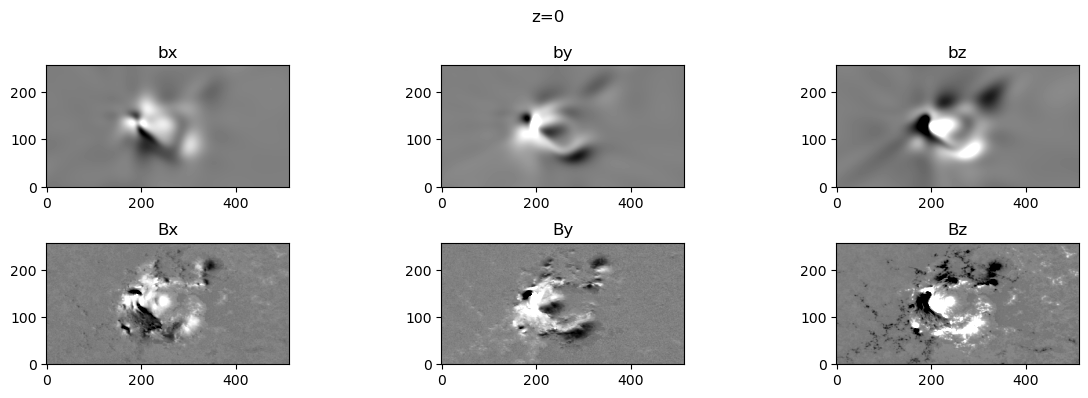

In [ ]:
plot_overview(b, B, z=0, b_norm=1000)

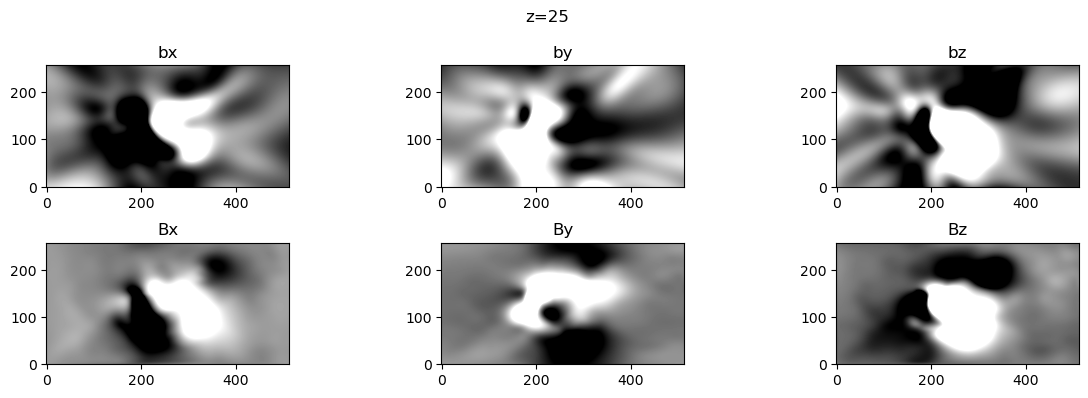

In [ ]:
plot_overview(b, B, z=25, b_norm=100)

In [ ]:
evaluate(b, B)

/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:58: RuntimeWarning: invalid value encountered in divide
  result['C_cs'] = 1 / M * np.sum((B * b).sum(-1) / vector_norm(B) / vector_norm(b))
/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:63: RuntimeWarning: divide by zero encountered in divide
  E_m = 1 / M * (vector_norm(b - B) / vector_norm(B)).sum()
/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:76: RuntimeWarning: invalid value encountered in divide
  result['sig_J_1e2_B'] = (vector_norm(np.cross(J, B, -1)) / vector_norm(B)).sum() / (vector_norm(J).sum() + 1e-6) * 1e2
/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:81: RuntimeWarning: invalid value encountered in divide
  result['L1_B'] = (vector_norm(np.cross(curl(B), B, -1)) ** 2 / vector_norm(B) ** 2).mean()


{'C_vec': 0.8032465659951291,
 'C_cs': nan,
 "E_n'": 0.05328923405622066,
 "E_m'": -inf,
 'eps': 1.1093959272983347,
 'sig_J_1e2': 52.66805478987423,
 'sig_J_1e2_B': nan,
 'L1': 22.912212,
 'L2': 15.471119,
 'L1_B': nan,
 'L2_B': 175.9493615073281,
 'L2n': 3.402760997414589,
 'L2n_B': 2414762027.1988177}

In [ ]:
metrics(b, B)

{'c_vec': 0.8032465659951291,
 'c_cs': 0.2759833401103955,
 'c_cs_ep': 0.27598334010891895,
 "E_n'": 0.05328923405622066,
 "E_m'": -0.9787255758424065,
 "E_m'_ep": -3219330.0663252166,
 'eps': 1.1093959272983347}

In [ ]:
import matplotlib.pyplot as plt

[<matplotlib.lines.Line2D>]

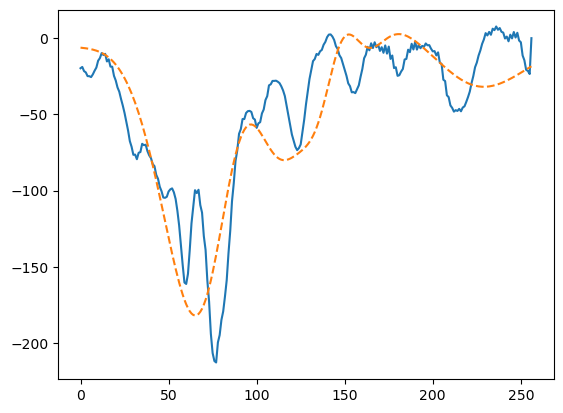

In [ ]:
plt.plot(B[..., 5, 2][100, :])
plt.plot(b[..., 5, 2][100, :], '--')